In [758]:
'''
Prediction 1:
scenario_1: The word test appears in at least in one field
scenario_2: All fields are at most the same
scenario_3: One word field
scenario_4: Random characters in at least in one field
'''
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
import random
import matplotlib
import matplotlib.pyplot as plt
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split
nltk.download('words')
nltk.download('stopwords')

[nltk_data] Downloading package words to
[nltk_data]     /Users/darrylbalderas/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/darrylbalderas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [759]:
# import spam collection messages
column_names = ['label', 'title']
message_data = pd.read_table("SMSSpamCollection", names=column_names)

In [760]:
# Remove rows that contain spam label and reset indexes
message_data = message_data.drop(message_data[message_data.label == "spam"].index).reset_index(drop=True)

In [761]:
# Drop label column
message_data = message_data.drop('label', axis=1)

In [762]:
# Show a peek in the column
message_data.head(10)

,title
0,The quick onyx goblin jumps over the lazy dwarf
1,"Go until jurong point, crazy.. Available only ..."
2,Ok lar... Joking wif u oni...
3,U dun say so early hor... U c already then say...
4,"Nah I don't think he goes to usf, he lives aro..."
5,Even my brother is not like to speak with me. ...
6,As per your request 'Melle Melle (Oru Minnamin...
7,I'm gonna be home soon and i don't want to tal...
8,I've been searching for the right words to tha...
9,I HAVE A DATE ON SUNDAY WITH WILL!!


In [763]:
message_data.shape

(4826, 1)

In [764]:
# load words into a dictionary for faster loading
english_words = dict.fromkeys(words.words(), None)

In [765]:
def is_word(word):
    """
    Check if word is in english dictionary
    """
    try:
        x = english_words[word]
        return True
    except:
        return False


def get_false_word_indexes(data, percentage):
    """
    Check for words that are not words and return their index
    """
    indexes = []
    for index, message in enumerate(data['title']):
        false_word_count = 0
        for word in message.split():
            if not is_word(word):
                false_word_count += 1
                if false_word_count/len(message) > false_word_percentage:
                    indexes.append(index)
                    break
    return indexes

def remove_single_words(data):
    """
    Returns a single words from the dataframe
    """
    indexes = []
    for index, message in enumerate(data['title']):
        if len(message.split()) > 1:
            continue
        indexes.append(index)
    return indexes
    

In [766]:
false_word_percentage = 0.02
indexes = get_false_word_indexes(message_data, false_word_percentage)
print('{} number of indexes will be deleted'.format(len(indexes)))

4742 number of indexes will be deleted
CPU times: user 22.2 ms, sys: 1.6 ms, total: 23.8 ms
Wall time: 22.9 ms


In [767]:
original_size = message_data.shape[0]
real_messages = message_data.drop(message_data.index[indexes]).reset_index(drop=True)
print('Data size went from {} to {}'.format(original_size, real_messages.shape[0]))

Data size went from 4826 to 84
CPU times: user 3.5 ms, sys: 1.81 ms, total: 5.31 ms
Wall time: 3.59 ms


In [768]:
real_messages.head()

,title
0,I see the letter B on my car
1,Ok i am on the way to home hi hi
2,I see a cup of coffee animation
3,Keep yourself safe for me because I need you a...
4,Or ill be a little closer like at the bus stop...


In [769]:
indexes = remove_single_words(real_messages)
print('{} number of indexes will be deleted'.format(len(indexes)))
no_single_messages = real_messages.drop(real_messages.index[indexes]).reset_index(drop=True)
print('Data size went from {} to {}'.format(real_messages.shape[0], no_single_messages.shape[0]))

8 number of indexes will be deleted
Data size went from 84 to 76
CPU times: user 1.31 ms, sys: 87 µs, total: 1.4 ms
Wall time: 1.37 ms


In [770]:
def add_test_message(sentence):
    words = sentence.split()
    prob = random.random()
    if prob < 0.45:
        choice = 0
    elif prob < 0.90:
        choice = len(words)
    else:
        choice = random.randint(0,len(words))
    update_sentence = " ".join(words[:choice]) + " test " + " ".join(words[choice:])
    return update_sentence.strip()

In [812]:
# Show that the test message in a random index of the sentence
add_test_message("Hello my name darryl")

'test Hello my name darryl'

In [772]:
def shuffle_dataframe(df, num_shuffles):
    for x in range(num_shuffles):
        for column in df.columns:
            df[column] = df[column].sample(frac=1).reset_index(drop=True)
    return df

In [773]:
stopwords_map = {word:0 for word in stopwords.words('english')}
print
punctation_map = {word:0 for word in string.punctuation}
def text_process(mess):
    nopunc = [char for char in mess if char not in punctation_map]
    nopunc = ''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords_map])

def create_default_scenario(df):
    scenario = pd.DataFrame(df)
    scenario['subtitle'] = scenario['title']
    scenario['message'] = scenario['title']
    for column in df.columns:
        scenario[column] = scenario[column].apply(text_process)
    return scenario

In [774]:
def create_scenario_one(messages):
    df = create_default_scenario(messages)
    df = shuffle_dataframe(df, num_shuffles=30)
    for index in df.index:
        prob = random.random()
        choice = random.choice(df.columns)
        if prob < 0.05:
            df.loc[index][choice] = add_test_message(df.loc[index][choice])
        elif prob < 0.15:
            columns = list(df.columns)
            df.loc[index][choice] = add_test_message(df.loc[index][choice])
            columns.remove(choice)
            choice = random.choice(columns)
            df.loc[index][choice] = add_test_message(df.loc[index][choice])
        else:
            for column in df.columns:
                df.loc[index][column] = add_test_message(df.loc[index][column])
    return df

In [775]:
def create_scenario_two(messages):
    return create_default_scenario(messages)

In [776]:
def create_scenario_three(messages):
    df = create_default_scenario(messages)
    for column in df.columns:
        df[column] = df[column].apply(lambda x: x.split()[0])
    return df

In [777]:
def create_random_chars():
    letters = string.ascii_letters
    num_chars = random.randint(5, 12)
    return "".join([random.choice(string.ascii_letters) for _ in range(num_chars)])

def create_scenario_four(messages):
    df = create_default_scenario(messages)
    for column in df.columns:
        df[column] = df[column].apply(lambda x: create_random_chars())
    return df

In [778]:
create_scenario_one(no_single_messages).to_csv("test_messages.csv")

In [779]:
create_scenario_two(no_single_messages).head()

,title,subtitle,message
0,Ok way home hi hi,Ok way home hi hi,Ok way home hi hi
1,couldnt say dying man feel sad go wanted know ...,couldnt say dying man feel sad go wanted know ...,couldnt say dying man feel sad go wanted know ...
2,need say anything know outsider,need say anything know outsider,need say anything know outsider
3,idea,idea,idea
4,know people still town,know people still town,know people still town


In [780]:
create_scenario_three(no_single_messages).head()

,title,subtitle,message
0,Ok,Ok,Ok
1,couldnt,couldnt,couldnt
2,need,need,need
3,idea,idea,idea
4,know,know,know


In [781]:
create_scenario_four(no_single_messages).head()

,title,subtitle,message
0,YdOKhSdnsHe,LZCLFy,zfYbS
1,pePhJyQ,BKKODw,HAGVlhJYZ
2,DNIcnVPTgbvL,BCTXn,zYYMA
3,qknQEtja,kNiWLmzWrst,zoLyvhnJZgzR
4,lMwpDyJQTs,trEWaeeqkz,dHPNIXLt


In [782]:
# concatenate dataframes that has possible test messages
indexes = remove_single_words(real_messages)
no_single_messages = real_messages.drop(real_messages.index[indexes]).reset_index(drop=True)
test_messages = pd.concat([create_scenario_one(no_single_messages),
          create_scenario_two(no_single_messages),
          create_scenario_three(no_single_messages),
          create_scenario_four(no_single_messages)])

In [783]:
# add label column for distinguish that this is a test message 
test_messages['label'] = 1
test_messages.head()

,title,subtitle,message,label
0,test Ok come ur home half hour,know mood today test,test Carry disturbing,1
1,know people hit fuck yes test,test Ok come ur home half hour,test turns stereo love mi phone unknown album,1
2,test Ok anyway need change said,U made appointment test,test could ask carlos could get anybody else chip,1
3,could ask carlos could get anybody else chip test,Ok another number test,test still havent collected dough pls let know...,1
4,test Ok need tell anything going sleep good night,test need say anything know outsider,test Well meant opposed drunken night,1


In [784]:
indexes = remove_single_words(real_messages)
no_single_messages = real_messages.drop(real_messages.index[indexes]).reset_index(drop=True)
no_test_messages = create_default_scenario(no_single_messages)
no_test_messages = shuffle_dataframe(no_test_messages, num_shuffles=50)

In [785]:
no_test_messages['label'] = 0
no_test_messages.head()

,title,subtitle,message,label
0,Ok leave need ask,Ok way railway,Please tell special stock talking,0
1,Carlos taking sweet time usual let know patty ...,cant believe attached seeing every day know be...,Ok shall talk,0
2,Ok ill tell company,see half hour,Ok leave need ask,0
3,know people still town,food,Come room point iron plan weekend,0
4,Ok another number,idea,Ok way home hi hi,0


In [786]:
# concatenate dataframes test and not test messages
for x in range(50):
    df = pd.concat([test_messages, no_test_messages]).sample(frac=1).reset_index(drop=True)

In [787]:
df.head()

,title,subtitle,message,label
0,ihcVMIkmACWN,oOFBSwbGllW,ZOYKnPVrf,1
1,ngrRkth,BrBFipUBmTB,EMwNBc,1
2,test turns stereo love mi phone unknown album,Would smoking help us work difficult time test,Sitting mu waiting everyone get suite take sho...,1
3,mwWTTVnU,qADrB,BlkMTXowp,1
4,mIEXxfqp,osOXEnnprH,rtGZF,1


In [788]:
demonstrate_df = pd.DataFrame(df)
demonstrate_df['title_length'] = demonstrate_df['title'].apply(lambda x: len(x.split()))
demonstrate_df['subtitle_length'] = demonstrate_df['subtitle'].apply(lambda x: len(x.split()))
demonstrate_df['message_length'] = demonstrate_df['message'].apply(lambda x: len(x.split()))

In [789]:
demonstrate_df.groupby('label').describe()

message_length                                                 \
               count      mean       std  min  25%  50%   75%   max   
label                                                                 
0               76.0  5.592105  3.339372  1.0  3.0  5.0  7.00  16.0   
1              304.0  2.384868  2.906673  1.0  1.0  1.0  1.25  16.0   

      subtitle_length            ...              title_length            \
                count      mean  ...    75%   max        count      mean   
label                            ...                                       
0                76.0  5.592105  ...   7.00  16.0         76.0  5.592105   
1               304.0  2.391447  ...   1.25  17.0        304.0  2.381579   

                                            
            std  min  25%  50%   75%   max  
label                                       
0      3.339372  1.0  3.0  5.0  7.00  16.0  
1      2.922394  1.0  1.0  1.0  1.25  17.0  

[2 rows x 24 columns]

In [790]:
demonstrate_df['title_length'].sort_values(ascending=False)[:5]

163    17
34     16
295    15
110    15
210    15
Name: title_length, dtype: int64

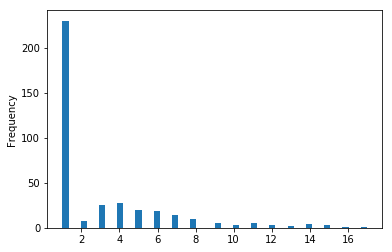

In [791]:
demonstrate_df['title_length'].plot(bins=50,kind='hist')

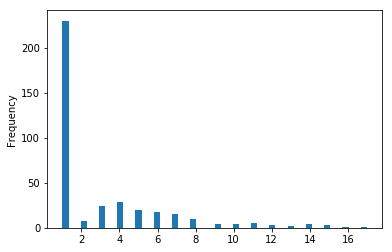

In [792]:
demonstrate_df['subtitle_length'].plot(bins=50,kind='hist')

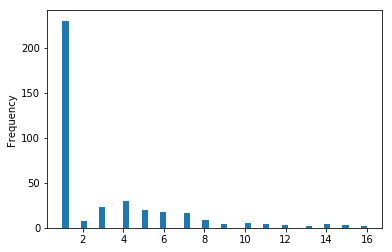

In [793]:
demonstrate_df['message_length'].plot(bins=50,kind='hist')

In [794]:
# Cutoff was based on the graphs above 
cutoff = 10
criteria1 = demonstrate_df['message_length'] < cutoff
criteria2 = demonstrate_df['subtitle_length'] < cutoff
criteria3 = demonstrate_df['title_length'] < cutoff
df = demonstrate_df[criteria1 & criteria2 & criteria3]

In [795]:
def create_cvec_df(df, column, cvec):
    X = df[column]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=45)
    cvec.fit(X_train)
    train = pd.DataFrame(cvec.transform(X_train).todense())
    test = pd.DataFrame(cvec.transform(X_test).todense())
    return {'train':train, 'test':test, 'ytrain':y_train, 'ytest': y_test}, cvec

In [796]:
cvec = CountVectorizer(analyzer=text_process)
df = demonstrate_df.drop(['message_length', 'subtitle_length', 'title_length'], axis=1)
title_df, cvec = create_cvec_df(df, 'title', cvec)
subtitle_df, cvec = create_cvec_df(df, 'subtitle',cvec)
message_df,cvec = create_cvec_df(df, 'message',cvec)
df.head(20)

,title,subtitle,message,label
0,ihcVMIkmACWN,oOFBSwbGllW,ZOYKnPVrf,1
1,ngrRkth,BrBFipUBmTB,EMwNBc,1
2,test turns stereo love mi phone unknown album,Would smoking help us work difficult time test,Sitting mu waiting everyone get suite take sho...,1
3,mwWTTVnU,qADrB,BlkMTXowp,1
4,mIEXxfqp,osOXEnnprH,rtGZF,1
5,yGavxQHsRO,NETfQuRBSu,HQsefQbrGj,1
6,da run activate full version da,Ok need tell anything going sleep good night,want kiss feel next,0
7,ill little closer like bus stop street,Ok prob,Ok ill tell company,0
8,IrrVvxCldU,WHImKqEUBT,PrsCJR,1
9,TLlmAZ,OnrcM,ZWuMcJYi,1


In [797]:
train = pd.concat([title_df['train'],subtitle_df['train'],message_df['train']], axis=1)
test = pd.concat([title_df['test'],subtitle_df['test'],message_df['test']], axis=1)

In [798]:
# showcasing ytrain labels
print(title_df['ytrain'].head())
print(subtitle_df['ytrain'].head())
print(message_df['ytrain'].head())

101    0
280    1
180    1
13     1
161    1
Name: label, dtype: int64
101    0
280    1
180    1
13     1
161    1
Name: label, dtype: int64
101    0
280    1
180    1
13     1
161    1
Name: label, dtype: int64


In [799]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def show_results(clf, data, train, test):
    print("Classifier: {}\n".format(clf.fit(train , data['ytrain'])))
    predictions = clf.predict(test)
    show_wrong_classifictions(predictions, 20)
    print(classification_report(data['ytest'], predictions))
    print(confusion_matrix(data['ytest'], predictions))
    print("\n")
    print("Average K-fold Accuracy score: {}".format(np.mean(cross_val_score(clf, train, data['ytrain'] , cv=5))))
    return clf
    
def show_wrong_classifictions(predictions, num_predictions):
    for index, prediction in enumerate(predictions[:num_predictions]):
        if prediction != message_df['ytest'].iloc[index]:
            print("Title: {}".format(demonstrate_df.loc[index]['title']))
            print("Subtitle: {}".format(demonstrate_df.loc[index]['subtitle']))
            print("Message: {}".format(demonstrate_df.loc[index]['message']))
            print("Classifier's Prediction: {}".format(prediction))
            print("Actual Prediction: {}".format(message_df['ytest'].iloc[index]))
            print("\n")
            
def show_sample_classifications(clf, cvec):
    title = ["W","Hello", "test Synergy", "Footwear Sale", "test message"]
    subtitle = ["W","Hello", "Synergy", "24 hour sale", "message"]
    message = ["W","Hello", "test Synergy", "Buy one get one free", "test message"]
#     title = ["W","Hello"]
#     subtitle = ["W","Hello"]
#     message = ["W","Hello"]
    inputs = convert_fields(title, subtitle, message, cvec)
    predictions = clf.predict(inputs)
    for i, prediction in enumerate(predictions):
        if prediction == 1:
            print("Title: {} .. Subtitle: {} .. Message: {} ----> Test message".format(title[i], subtitle[i], message[i]))
        else:
            print("Title: {} .. Subtitle: {} .. Message: {} ----> Not a test message".format(title[i], subtitle[i], message[i]))

            
def convert_fields(title, subtitle, message, cvec):
    title_cvec = pd.DataFrame(cvec.transform(title).todense())
    subtitle_cvec = pd.DataFrame(cvec.transform(subtitle).todense())
    message_cvec = pd.DataFrame(cvec.transform(message).todense())
    final_df = pd.concat([title_cvec, subtitle_cvec, message_cvec], axis=1)
    return final_df

In [800]:
classifier = MultinomialNB()
show_results(classifier, message_df, train, test)
show_sample_classifications(classifier, cvec)

Classifier: MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Title: ill little closer like bus stop street
Subtitle: Ok prob
Message: Ok ill tell company
Classifier's Prediction: 0
Actual Prediction: 1


Title: TLlmAZ
Subtitle: OnrcM
Message: ZWuMcJYi
Classifier's Prediction: 0
Actual Prediction: 1


Title: monthly amount terrible pay anything till 6months finishing school
Subtitle: cant believe attached seeing every day know best get babe go teach class midnight test
Message: take like noon test
Classifier's Prediction: 0
Actual Prediction: 1


              precision    recall  f1-score   support

           0       0.60      1.00      0.75        21
           1       1.00      0.85      0.92        93

   micro avg       0.88      0.88      0.88       114
   macro avg       0.80      0.92      0.83       114
weighted avg       0.93      0.88      0.89       114

[[21  0]
 [14 79]]


Average K-fold Accuracy score: 0.7668763102725367
Title: W .. Subtitle: W .. Message: W -

In [801]:
from sklearn.svm import SVC
svm_classifier = SVC()
show_results(svm_classifier, message_df, train, test)
show_sample_classifications(svm_classifier, cvec)

Classifier: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Title: know people hit fuck yes
Subtitle: couldnt say dying man feel sad go wanted know would probably gone late night
Message: way ur home
Classifier's Prediction: 1
Actual Prediction: 0


              precision    recall  f1-score   support

           0       1.00      0.62      0.76        21
           1       0.92      1.00      0.96        93

   micro avg       0.93      0.93      0.93       114
   macro avg       0.96      0.81      0.86       114
weighted avg       0.94      0.93      0.92       114

[[13  8]
 [ 0 93]]


Average K-fold Accuracy score: 0.8757512229210344
Title: W .. Subtitle: W .. Message: W ----> Test message
Title: Hello .. Subtitle: Hello .. Message: Hello ----> Test message
Title: test Synergy .. Subtitle: Syne

/Users/darrylbalderas/PycharmProjects/test-message-detector/venv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/darrylbalderas/PycharmProjects/test-message-detector/venv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/darrylbalderas/PycharmProjects/test-message-detector/venv/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 